# Demonstration of Image Comparison
This notebook discusses basics of registration, resampling, and image comparison.

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Eric Einspänner
<br>
Contributor: Nastaran Takmilhomayouni

First version: 6th of July 2023


Copyright 2023 Clinic of Neuroradiology, Magdeburg, Germany

License: Apache-2.0

## Table of contents
1. [Initial set-up](#Initial-Set-Up)
2. [Load image/volume](#Load-the-Image/Volume)
3. [Translation](#Translation)
    - [Exercise (Translation)](#exercise-translation)
    - [Exercise (Translation - difficult)](#exercise-translation---difficult)
4. [Rotation](#Rotations)
    - [Exercise (Rotation)](#exercise-rotation)
5. [Affine Transformation](#Affine-Transformation)
6. [Resampling](#Resampling)
7. [Interpolation](#Interpolation)
8. [MAE](#Mean-Absolute-Error-MAE)
9. [SSIM](#Structural-Similarity-SSIM)
10. [IoU](#Intersection-of-The-Union-IOU)
11. [Testing group differences](#Testing-Group-Differences)
12. [Normalizing metrics](#Normalizing-Metrics)

## Initial Set-Up

In [ ]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget


In [ ]:
# Initial imports etc
import imageio
import pandas as pd
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from Utilities.downloaddata import fetch_data as fdata
import SimpleITK as sitk
import Utilities.gui

In [ ]:
def format_and_render_plot():
    '''
    Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.
    '''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

## Load the Image/Volume
In this chapter, we'll leverage data use data from the OASIS to compare the brains of different populations: young and old, male and female, healthy and diseased.

In [ ]:
# Load the directory (volume)
folder_path = 'Data/Brain/SE000001/MR000000'

# Load the volume
vol = imageio.volread(folder_path)
print(vol.shape)

# save the middle slice as separat image
middle_slice = vol.shape[0] // 2
im = vol[middle_slice,:,:]

## Translation
Image translation is like shifting or moving an image from one place to another within a picture. Just like sliding a puzzle piece on a table, image translation shifts the whole picture in different directions—left, right, up, or down.

The line `xfm = ndi.shift(im, shift=(10, 15))` is the magic. It shifts the brain picture 10 steps to the right and 15 steps down. It's like sliding the brain within the picture.

In [ ]:
# Translate the brain towards the center
xfm = ndi.shift(im, shift=(10, 15))

# Plot the original and adjusted images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

### Exercise (Translation)
Now move the picture 12 steps to the left and 8 steps up and plot both images!

In [ ]:
# Write your code here (the solution is below)







In [ ]:
### Solution
# Translate the brain towards the center
xfm = ndi.shift(im, shift=(-12, -8))

# Plot the original and adjusted images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

### Exercise (Translation - difficult)
First, find the center point in the image array and the center of mass (COM) of the brain. Then, translate the image to the center.

Note: You need the `ndi.center_of_mass()` function to find the COM (x and y coordinate).

In [ ]:
# Write your code here (the solution is below)







In [ ]:
# Find image center of mass
com = ndi.center_of_mass(im)

# Calculate amount of shift needed
d0 = 128 - com[0]
d1 = 128 - com[1]

print(f'COM: {com}, d0: {d0}, d1: {d1}')

# Translate the brain towards the center
xfm = ndi.shift(im, shift=(d0, d1))

# Plot the original and adjusted images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

## Rotations
In cases where an object is angled or flipped, the image can be rotated. Using `ndi.rotate()`, the image is rotated from its center by the specified degrees from the right horizontal axis.

In [ ]:
# Rotate the shifted image
xfm = ndi.rotate(xfm, angle=-30, reshape=False)

# Plot the original and transformed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

### Exercise (Rotation)
First move the image 20 steps to the left and upwards. Then rotate the shifted image counterclockwise by 45°.

In [ ]:
# Write your code here (the solution is below)







In [ ]:
### Solution
# Shift the image towards the center
xfm = ndi.shift(im, shift=(-20, -20))

# Rotate the shifted image
xfm = ndi.rotate(xfm, angle=45, reshape=False)

# Plot the original and transformed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

## Affine Transformation
Affine transformation is a way to change the shape, size, and position of an image. It's like using a special set of rules to stretch, shrink, rotate, or skew an image, while keeping its lines straight and parallel.

- What is Affine Transformation?

It's a mathematical way to adjust images using operations like scaling (changing size), rotation, translation (shifting), and shearing (changing angles).

- How Does It Work?

Affine transformations use matrix multiplication to alter an image. Each transformation, like scaling or rotating, is represented by a matrix that applies specific changes to the image.

![Affine Transformation matrices](../ImageAnalysis/Data/Images/affine_transform.png)

Experiment with the values in the matrix and observe the changes.

In [ ]:
# Define the affine transform matrix
mat = np.array([[0.8, -0.4, 90], [0.4, 0.8, -6.0], [0, 0, 1]])
print(mat)

# Apply the affine transform matrix to image data
xfm = ndi.affine_transform(im, mat)

# Plot the original and transformed images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[1].imshow(xfm)
format_and_render_plot()

## Resampling
Images can be collected in a variety of shapes and sizes. Resampling is a useful tool when these shapes need to be made consistent. Two common applications are:

- Downsampling: combining pixel data to decrease size
- Upsampling: distributing pixel data to increase size

In [ ]:
# Resample image
im_dn = ndi.zoom(im, zoom=0.25)
im_up = ndi.zoom(im, zoom=4.00)

# Plot the images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im_dn)
axes[1].imshow(im_up)
format_and_render_plot()

## Interpolation
Interpolation is how new pixel intensities are estimated when an image transformation is applied. It is implemented in SciPy using sets of spline functions.

Editing the interpolation `order` when using a function such as `ndi.zoom()` modifies the resulting estimate: higher orders provide more flexible estimates but take longer to compute.

In [ ]:
# Upsample "im" by a factor of 4
up0 = ndi.zoom(im, zoom=512/128, order=0)
up5 = ndi.zoom(im, zoom=512/128, order=5)

# Print original and new shape
print('Original shape:', im.shape)
print('Upsampled shape:', up5.shape)

# Plot close-ups of the new images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(up0[128:256, 128:256])
axes[1].imshow(up5[128:256, 128:256])
format_and_render_plot()

## Mean Absolute Error (MAE)
Cost functions and objective functions output a single value that summarizes how well two images match.

The MAE, for example, summarizes intensity differences between two images, with higher values indicating greater divergence.

In [ ]:
# Load the dcm file (image)
im1 = im

# Apply the affine transform matrix to image data
xfm = ndi.shift(im, shift=(-12, -8))
im2 = xfm

# Calculate image difference
err = im1 - im2

# Plot the difference
fig, axes = plt.subplots(1, 3)
axes[0].imshow(im)
axes[1].imshow(xfm)
axes[2].imshow(err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

# Calculate absolute image difference
abs_err = np.absolute(im1 - im2)

# Plot the difference
fig, axes = plt.subplots(1, 3)
axes[0].imshow(im)
axes[1].imshow(xfm)
axes[2].imshow(abs_err, cmap='seismic', vmin=-200, vmax=200)
format_and_render_plot()

# Calculate mean absolute error
mean_abs_err = np.mean(np.abs(im1 - im2))
print('MAE:', mean_abs_err)

## Structural Similarity (SSIM)
The Structural Similarity Index (SSIM) is a metric used to measure the similarity between two images. It evaluates how much one image is structurally similar to another, considering perceived changes in structural information, luminance, and contrast that humans typically notice.

- Luminance Comparison: Measures the difference in average luminance (brightness) between the two images.
- Contrast Comparison: Evaluates differences in contrast between corresponding image patches.
- Structure Comparison: Considers the structural information by comparing similarities in image structures using local mean, standard deviation, and cross-correlation.

The SSIM index ranges from -1 to 1. A value of 1 indicates perfect similarity, implying the two images are exactly the same. A value of -1 implies perfect dissimilarity.

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Compute SSIM between im and xfm
data_range=xfm.max() - xfm.min()
ssim_index = ssim(im, xfm, data_range=data_range)

print(f'SSIM: {ssim_index}')

## Intersection of The Union (IoU)

Another cost function is the IoU. The IoU is the number of pixels filled in both images (the intersection) out of the number of pixels filled in either image (the union).

In [ ]:
def intersection_of_union(im1, im2):
    i = np.logical_and(im1, im2)
    u = np.logical_or(im1, im2)
    return i.sum() / u.sum()

In [ ]:
# Try some other paramters by yourself
xfm = ndi.shift(im, shift=(-10, -10))
xfm = ndi.rotate(xfm, angle=-15, reshape=False)
intersection_of_union(xfm, im)

## ---------------------------------------------------------------------------------------------------------

## Testing Group Differences
Once measures have been extracted, double-check for dependencies within your data. This is especially true if any image parameters (sampling rate, field of view) might differ between subjects, or you pull multiple measures from a single image.

For the final exercises, we have combined demographic and brain volume measures into a pandas DataFrame (df).

In [60]:
# Load OASIS csv file
df = pd.read_csv('Data/Brain/oasis_all_volumes.csv', index_col=0)

In [66]:
# Print random sample of rows
print(df.head())

# Print prevalence of Alzheimer's Disease
print(df.alzheimers.value_counts())

# Print a correlation table excluding non-numeric columns
print(df.select_dtypes(include='number').corr())

               age sex  alzheimers  brain_vol    skull_vol  gray_matter_vol  \
ID                                                                            
OAS1_0001_MR1   74   F       False    807.935  1347.497879          470.698   
OAS1_0002_MR1   55   F       False    808.760  1151.269287          450.571   
OAS1_0003_MR1   73   F        True    860.255  1403.415054          492.974   
OAS1_0004_MR1   28   M       False   1058.202  1593.284910          585.270   
OAS1_0005_MR1   18   M       False   1263.391  1733.779281          732.734   

               white_matter_vol  csf_vol  
ID                                        
OAS1_0001_MR1           337.237   57.058  
OAS1_0002_MR1           358.189    9.478  
OAS1_0003_MR1           367.281   46.159  
OAS1_0004_MR1           472.932   32.609  
OAS1_0005_MR1           530.657   14.887  
alzheimers
False    332
True      93
Name: count, dtype: int64
                       age  brain_vol  skull_vol  gray_matter_vol  \
age          

Let's test the hypothesis that Alzheimer's Disease is characterized by reduced brain volume.

We can perform a two-sample t-test between the brain volumes of elderly adults with and without Alzheimer's Disease. In this case, the two population samples are independent from each other because they are all separate subjects.

t =  -10.27076306169677
p =  3.043550344658516e-22


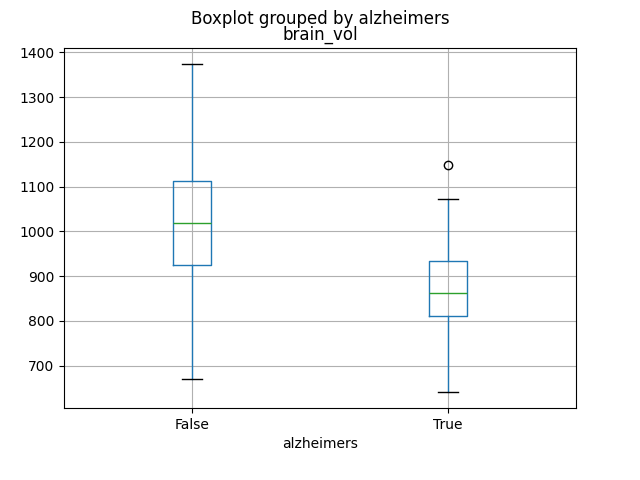

In [67]:
# Import independent two-sample t-test
from scipy.stats import ttest_ind

# Select data from "alzheimers" and "typical" groups
brain_alz = df.loc[df.alzheimers == True, 'brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'brain_vol']

# Perform t-test of "alz" > "typ"
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

# Show boxplot of brain_vol differences
df.boxplot(column='brain_vol', by='alzheimers')
plt.show()

## Normalizing Metrics
We previously saw that there was not a significant difference between the brain volumes of elderly individuals with and without Alzheimer's Disease.

But could a correlated measure, such as "skull volume" be masking the differences?

In [71]:
# Adjust `brain_vol` by `skull_vol`
df['adj_brain_vol'] = df.brain_vol / df.skull_vol

# Select brain measures by group
brain_alz = df.loc[df.alzheimers == True, 'adj_brain_vol']
brain_typ = df.loc[df.alzheimers == False, 'adj_brain_vol']

# Evaluate null hypothesis
results = ttest_ind(brain_alz, brain_typ)
print('t = ', results.statistic)
print('p = ', results.pvalue)

t =  -15.311391823926579
p =  2.019286086120867e-42


## Combining Two Images

There are a variety of ways we can overlay two (partially) overlapping images onto each other. The common approaches include:
1. Use of alpha blending.
2. Use of a checkerboard pattern with the pixel values in adjacent squares/boxes taken from each of the images.
3. When the pixel values are scalars (gray scale images), combine the two images in different channels, resulting in a color image.

We will start by loading two images whose content luckily overlaps in physical space. Before we can combine the two, we need to resample one of them so that they both occupy the same spatial region. In addition we should also rescale the intensities so that they occupy the same range. In our case we will map them to [0,255], based on the desired windowing.

In [ ]:
img1 = sitk.ReadImage(fdata("training_001_mr_T1.mha"))
img2_original = sitk.ReadImage(fdata("training_001_ct.mha"))
img2 = sitk.Resample(img2_original, img1)

# Obtain foreground masks for the two images using Otsu thresholding, we use these later on.
msk1 = sitk.OtsuThreshold(img1,0,1)
msk2 = sitk.OtsuThreshold(img2,0,1)

Utilities.gui.MultiImageDisplay(image_list = [img1, img2],                   
                      title_list = ['image1', 'image2'],
                      figure_size=(9,3));

In [ ]:
# Having identified the desired intensity range for each of the 
# images using the GUI above, we use these values to perform intensity windowing and map the intensity values
# to [0,255] and cast to 8-bit unsigned int
img1_255 = sitk.Cast(sitk.IntensityWindowing(img1, windowMinimum=2, windowMaximum=657, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)
img2_255 = sitk.Cast(sitk.IntensityWindowing(img2, windowMinimum=-1018, windowMaximum=1126, 
                                             outputMinimum=0.0, outputMaximum=255.0), sitk.sitkUInt8)